# COMP 135 day07: Probabilistic Linear Regression

## Outline

* **Part 1: Showing samples from the posterior**
* * Learn to make plots of posterior distributions over the weights for simple regression problems


## Takeaways

* Hyperparameters like $\alpha$ (prior precision) and $\beta$ (likelihood precision) matter
* * We'll talk more about dealing with these next class

In [1]:
import numpy as np
import pandas as pd
import scipy.stats

In [2]:
np.set_printoptions(precision=3, suppress=False)

In [3]:
pd.options.display.float_format = '{:,.3g}'.format  # show 3 digits of precision

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.25)

# Part 1: The Probabilistic view of linear regression

### Task: Linear regression

Given $N$ observations of *paired* feature-outcome observations: $\{ x_n, t_n \}$. Each $x_n$ is a scalar, and each $t_n$ is a scalar.

We're also given a feature transform function $\phi$ which maps each $x_n$ to a vector in $M$-dimensional space. This function is known in advance. For now, we'll assume that the "feature transform" $\phi(x_n)$ just simply passes along the features $x_n$, while adding an additional offset or "intercept" feature that is always 1. This is a *simplifying* assumption for today.


We want to make good predictions of new outcomes $t_*$ given new features $x_*$.



In [5]:
def calc_features(x_N1, M=2):
    ''' Transform raw features into complete features useful for prediction
    
    Could do any non-linear transformations thought relevant for the problem.
    Here we'll just do an identity transform with an extra intercept feature.
    
    Args
    ----
    x_N1 : 2D array, shape (N, 1) = (n_examples,)
    
    Returns
    -------
    phi_NM : 2D array, shape (N, M) = (n_examples, n_transformed_features)
        First column will contain all ones (a bias or intercept feature)
        Second column will just include the raw features
    '''
    assert x_N1.ndim == 2
    assert x_N1.shape[1] == 1
    N = x_N1.shape[0]
    phi_NM = np.zeros((N, M))
    phi_NM[:,0] = 1
    phi_NM[:,1] = x_N1[:,0]
    return phi_NM

## Exercise 1a: Obtain transformed features $\phi(x_n)$ when $x_n = [2.0]$

In [6]:
# TODO call calc_features() for the vector x_n = [2.0]


## Define the Likelihood

Each observation (indexed by $n$) is drawn iid from a Normal as follows:

$$
t_n \sim \mathcal{N}( t_n | w^T \phi(x_n), \beta^{-1} )
$$

The key properties here are:
* The *mean* is a linear function of the transformed features.
* The *precision* (inverse variance) is assumed a known value defined by parameter $\beta > 0$

## Define the  Prior

For now, we'll assume that weights come from a zero mean prior with some covariance determined by a scalar parameter $\alpha$:

$$
w \sim \mathcal{N}( 0, \alpha^{-1} I_M )
$$

A zero mean prior makes sense if we don't know if the slope should be negative or positive.

### Parameter we'll treat as a random variable: $w$

* Weights vector: $w = [w_1, w_2, \ldots w_M]^T$, so $w \in \mathbb{R}^M$

### Parameters we'll treat as fixed: $\alpha$ and $\beta$


* Prior precision $\alpha > 0$

The larger $\alpha$ is, the more confident we are in the weight values before seeing any data.

* Likelihood precision $\beta > 0$

The larger $\beta$ is, the less the observed $t$ values vary from the predicted mean.

## Create a simple toy data for analysis

Just execute the cells below to get the sense of how to generate toy data from this model

We'll manually intervene to set the weight vector to a known value. This makes it easy to tell if our learning is working later on.

In [9]:
N = 2000  # Number of examples we observe
M = 2     # Number of transformed features

In [10]:
# Create reproducible pseudorandom number generator
prng = np.random.RandomState(0)

Create the weight vector we'll use to generate our dataset. Set an intercept of 1.2 and a slope of -0.75

In [12]:
true_w_M = np.asarray([1.2, -0.75])

Create a "true" alpha value which controls the prior precision

In [13]:
true_alpha = 0.01

Create a "true" beta which defines the likelihood precision

In [14]:
true_beta = 0.5

Create observed features $x$ and do a "feature transform" that just adds a column of all ones (an "intercept" feature)

In [15]:
x_N1 = prng.uniform(low=-7, high=7, size=N)[:,np.newaxis]
phi_NM = calc_features(x_N1)

Generate outputs t using our assumed model

In [16]:
t_N = prng.normal( np.dot(phi_NM, true_w_M), 1.0/true_beta)

## Visualize the toy dataset

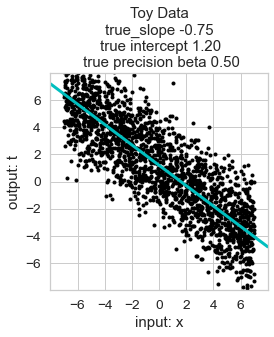

In [19]:
plt.plot(x_N1, t_N, 'k.');

ax_h = plt.gca()
ax_h.set_aspect('equal', 'box');
ax_h.set_xlim([-8, 8]); ax_h.set_xticks([-6, -4, -2, 0, 2, 4, 6]);
ax_h.set_ylim([-8, 8]); ax_h.set_yticks([-6, -4, -2, 0, 2, 4, 6]);

xgrid_G = np.linspace(-8, 8, 100)[:,np.newaxis]
plt.plot(xgrid_G, np.dot(calc_features(xgrid_G), true_w_M), 'c-', linewidth=3);

plt.xlabel('input: x');
plt.ylabel('output: t');
plt.title("Toy Data\n true_slope %.2f \n true intercept %.2f\n true precision beta %.2f" % (
    true_w_M[1], true_w_M[0], true_beta));

## Posterior over weights

Recall the formulas for the posterior over the weight vector $w$, simplified for our zero-mean, diagonal-covariance prior on $w$:

\begin{align}
p( w | t) &= \text{MVNormPDF}( w | m, S )
\\
S^{-1} &= \alpha I_M + \beta \Phi^T \Phi
\\
m &= \beta S \Phi^T \mathbf{t}
\end{align}

In other words, the posterior is a Gaussian distribution, where:
* $m$ is the mean vector of shape $(M,)$ 
* $S$ is the covariance matrix of shape $(M, M)$


The ingredients of these formulas are:
* $\alpha > 0$ : prior precision
* $\beta > 0$ : likelihood precision
* $\Phi$ : N x M matrix of transformed features ("inputs")
* $\mathbf{t}$ : N-dimensional vector of observed outputs
* $I_M $: M x M [identity matrix](https://en.wikipedia.org/wiki/Identity_matrix) (can create with `np.eye(M)`)

## Exercise 1b: Compute the parameters of the posterior

Translate the formulas above into concrete NumPy expressions that compute the mean $m$ and covariance $S$:m

In [26]:
def calc_parameters_of_posterior(phi_NM, t_N, alpha=0.1, beta=0.1):
    ''' Compute parameters of the posterior for weights w
    
    Args
    ----
    phi_NM : 2D array, shape (N,M)
        Each row is a feature vector for one example
    t_N : 1D array, shape (N,)
        Each row is a output scalar value for one example
    alpha : positive scalar
        Prior precision
    beta : positive scalar
        Likelihood precision
    
    Returns
    -------
    m_M : posterior mean vector, shape (M,)
    S_MM : posterior covariance matrix, shape (M, M)
    '''
    N, M = phi_NM.shape
    invS_MM = np.eye(M) # TODO determine the inverse of S via formulas above
    S_MM = np.linalg.inv(invS_MM) # Invert to get the value of S (covariance matrix)
    
    m_M = np.zeros(M) # TODO determine the mean vector via formulas above
    return m_M, S_MM

## Exercise 1c: Compute posterior parameters when given all N=2000 observations

How close is the posterior mean to the "true" vector of weights that generated the data?

How "uncertain" is the posterior (look at variance values in the covariance matrix)

In [34]:
# TODO call calc_parameters_of_posterior(...) with the toy dataset we generated above
# Use the "true" alpha/beta values

# TODO inspect the mean and covariance that is returned. Does it make sense?

## Exercise 1d: Visualize samples from the posterior as more data is observed

Do you see the posterior "concentrate" its mass on the true value as more data is observed?


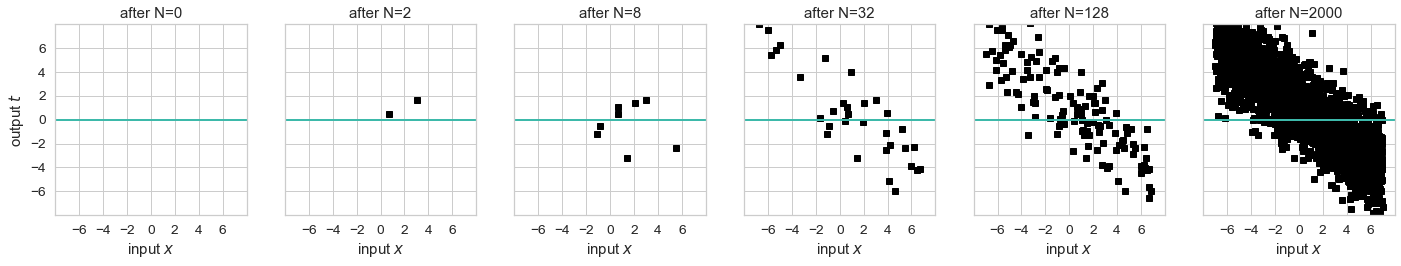

In [35]:
# Define the number of observations to look at to make a posterior
N_values = [0, 2, 8, 32, 128, N]
C = len(N_values)

# Define the number of samples from the posterior to visualize
R = 10

fig_h, axgrid = plt.subplots(nrows=1, ncols=C, sharex=True, sharey=True, figsize=(C * 4, 4))

for col_id, Ncur in enumerate(N_values):

    # Create the posterior from the first Ncur observations
    # Hint: use phi_NM[:10] to get the first 10 observations
    m_M, S_MM = np.zeros(M), np.eye(M) # TODO call calc_parameters_of_posterior(...)
    
    # Activate current subplot and get its handle
    ax_h = axgrid[col_id]
    
    # Show the observed data
    ax_h.plot(x_N1[:Ncur], t_N[:Ncur], linestyle='', marker='s', color='black')

    for rr in range(R):
        # Create a uniform grid of possible x values, to use in making predictions
        xgrid_G = np.linspace(-8, 8, 100)[:,np.newaxis]

        # Draw one sample vector from the posterior with the parameters defined above
        wsamp_rr_M = m_M # TODO call prng.multivariate_normal with mean m_M and covar S_MM
    
        # Produce the output values *t* that we get from the current sample of w_M
        # after multiplying that weight vector with our features
        tsamp_rr_G = np.dot(calc_features(xgrid_G), wsamp_rr_M)

        # Show a plot of this sample on current axis
        ax_h.plot(xgrid_G, tsamp_rr_G, '-');

    # Make plots pretty and standardized
    ax_h.set_aspect('equal', 'box');
    ax_h.set_xlim([-8, 8]); ax_h.set_xticks([-6, -4, -2, 0, 2, 4, 6]);
    ax_h.set_ylim([-8, 8]); ax_h.set_yticks([-6, -4, -2, 0, 2, 4, 6]);
    ax_h.set_xlabel('input $x$')
    if col_id == 0:
        ax_h.set_ylabel('output $t$')
    ax_h.set_title('after N=%d' % Ncur)

## Exercise 1e: Visualize samples from posterior if we use WRONG values for $\beta$

The true beta value we used to generate the data was $\beta = 0.5$

What if instead we use $\beta = 10$.... what will happen?

Compare and contrast with the above in 1d.

In [36]:
wrong_beta = 10.0

# Define the number of observations to look at to make a posterior
N_values = [0, 2, 8, 32, 128, N]
C = len(N_values)

# Define the number of samples from the posterior to visualize
R = 10

# TODO copy code from above, but use *wrong beta* instead of *true_beta*